In [1]:
import pandas as pd                                       #importing pandas
import numpy as np                                        #importing numpy
import copy                                               
import random
import matplotlib.pyplot as plt                           #importing matplotlib 
import seaborn as sns                                     #importing seaborn
from sklearn.model_selection import train_test_split      #importing scikit-learn's function for data splitting
from sklearn.linear_model import LinearRegression         #importing scikit-learn's linear regressor function
from sklearn.neural_network import MLPRegressor           #importing scikit-learn's neural network function
from sklearn.ensemble import GradientBoostingRegressor    #importing scikit-learn's gradient booster regressor function
from sklearn.metrics import mean_squared_error            #importing scikit-learn's root mean squared error function for model evaluation
from sklearn.model_selection import cross_validate        #improting scikit-learn's cross validation function
import random
import time
from tqdm import tqdm
from scipy.stats import ks_2samp, kruskal
import gurobipy as gp                                     #importing Gurobi

In [2]:
boxscores = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/fantasy_basketball/boxscores_dataset.csv')     #load boxscores dataset
# running locally
# boxscores = pd.read_csv('boxscores_dataset.csv')     #laoad boxscores dataset
boxscores = boxscores[(boxscores.playMin>=3) | (boxscores.playMin.isnull())]

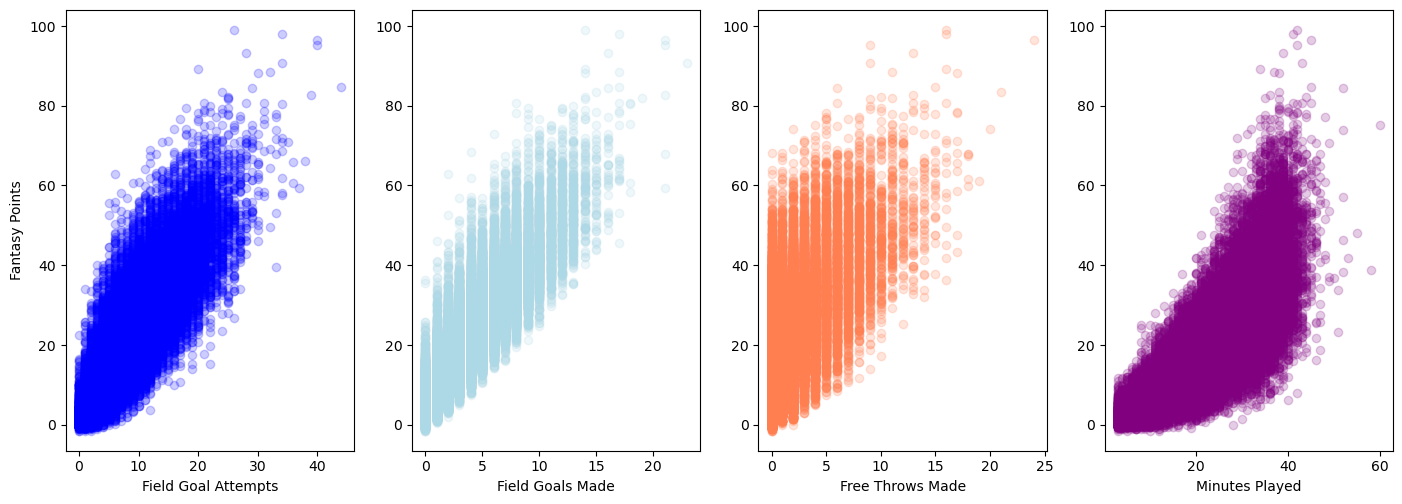

In [3]:
fig, (FGA, FGM, FTM, Min) = plt.subplots(1, 4, figsize=(14,5))
fig.tight_layout()

FGA.scatter(boxscores['playFGA'], boxscores['FantasyPoints'], c='blue', alpha = .2)
FGM.scatter(boxscores['playFGM'], boxscores['FantasyPoints'], c='lightblue', alpha = .2)
FTM.scatter(boxscores['playFTM'], boxscores['FantasyPoints'], c='coral', alpha = .2)
Min.scatter(boxscores['playMin'], boxscores['FantasyPoints'], c='purple', alpha = .2)

FGA.set_xlabel('Field Goal Attempts')
FGM.set_xlabel('Field Goals Made')
FTM.set_xlabel('Free Throws Made')
Min.set_xlabel('Minutes Played')

FGA.set_ylabel('Fantasy Points');

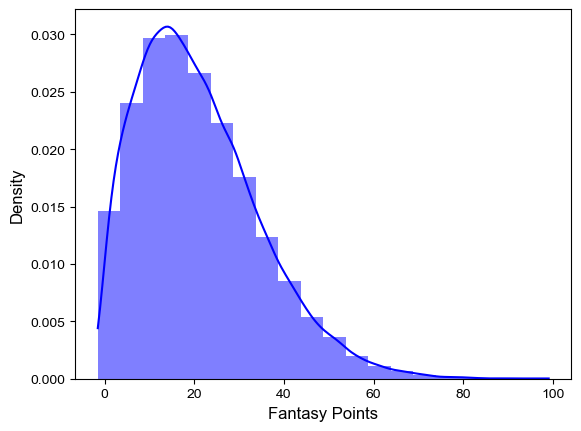

In [4]:
hplot = sns.histplot(boxscores['FantasyPoints'], color="blue", label="Fantasy Points", kde=True, stat="density", linewidth=0, bins=20)
hplot.set_xlabel("Fantasy Points", fontsize = 12)
hplot.set_ylabel("Density", fontsize = 12)
sns.set(rc={"figure.figsize":(14, 5)})

In [5]:
horizon=3

for column_name in ['playPTS','playAST','playTO','playSTL','playBLK','playTRB','playFGA','playFTA','play2P%','play3P%','playFT%','playMin','teamDayOff','FantasyPoints']:
    boxscores['moving' + column_name] = boxscores.groupby(['playDispNm'])[column_name].transform(lambda x: x.rolling(horizon, 1).mean().shift(1))                           #lagged moving average of numeric features 

In [6]:
boxscores.dropna(subset = ["movingplayPTS"], inplace=True)  

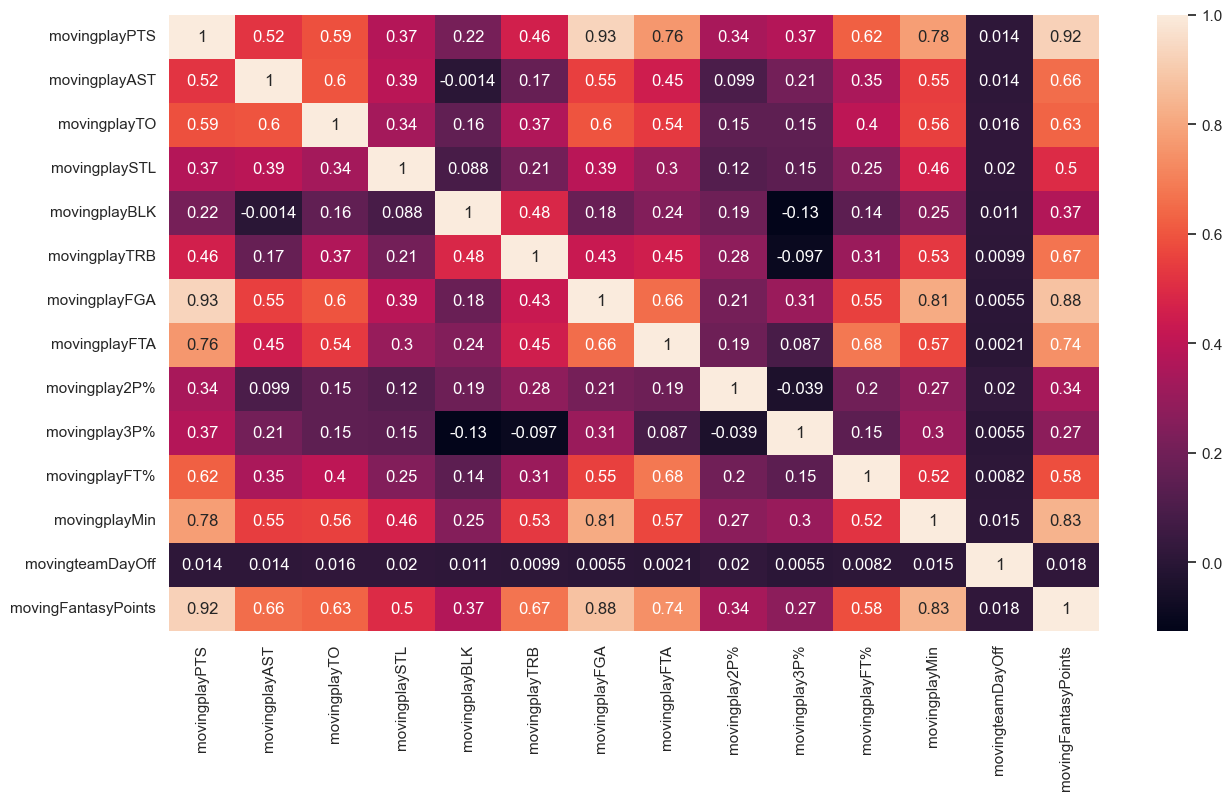

In [7]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(boxscores[['movingplayPTS', 'movingplayAST','movingplayTO','movingplaySTL','movingplayBLK','movingplayTRB','movingplayFGA','movingplayFTA','movingplay2P%','movingplay3P%','movingplayFT%','movingplayMin','movingteamDayOff','movingFantasyPoints']].corr(),annot=True)
plt.show()

In [8]:
boxscores['dummyTeamLoc'] = pd.get_dummies(data=boxscores['teamLoc'],drop_first=True)    #1 if the game is a home game, 0 if it is an away game
boxscores['dummyplayStat'] = pd.get_dummies(data=boxscores['playStat'],drop_first=True)  #1 if the player starts, 0 if the player comes from the bench

In [9]:
forecasting_data = boxscores[boxscores.gmDate != '2017-12-25']  #for model training, we exclude observation on December 25, 2017

In [10]:
X = forecasting_data[['movingplayAST','movingplayTO','movingplaySTL','movingplayBLK','movingplayTRB','movingplayFTA','movingplayFT%','dummyplayStat']]  #select the features that will be used for model training
y = forecasting_data['FantasyPoints']  #target set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)      #dataset splitting

linear_regressor = LinearRegression()                                                         #load linear regressor
linear_regressor.fit(X_train, y_train)                                                        #train the linear regression model
linear_regression_validation = cross_validate(linear_regressor, X_train, y_train, cv=5, return_train_score=True, return_estimator=True)

mlp = MLPRegressor(hidden_layer_sizes=(5,5), activation='relu')                               #load neural network
mlp.fit(X_train,y_train)                                                                      #train the neural network with a ReLU function and two hidden layers with 5 nodes each
mlp_validation = cross_validate(mlp, X_train, y_train, cv=5, return_train_score=True, return_estimator=True)

gb = GradientBoostingRegressor()                                                              #load a gradient boosting regressor
gb.fit(X_train, y_train)                                                                      #train a gradient boosting model
gb_validation = cross_validate(gb, X_train, y_train, cv=5, return_train_score=True, return_estimator=True)

c:\Users\mar\anaconda3\envs\hw3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [11]:
gb_validation['test_score']                            #print CV test score across each fold

array([0.50925091, 0.49918789, 0.48133256, 0.49762235, 0.50066819])

In [12]:
linear_regression_predictions = linear_regressor.predict(X_test)                              #make predictions based on the test set for the linear regression model
mlp_predictions = mlp.predict(X_test)                                                         #make predictions based on the test set for the neural network model
gb_predictions = gb.predict(X_test)                                                           #make predictions based on the test set for the gradient boosting model

linear_regression_mse = mean_squared_error(y_test, linear_regression_predictions)             #calculate the MSE for the linear regression model
mlp_mse = mean_squared_error(y_test, mlp_predictions)                                         #calculate the MSE for the neural network model
gb_mse = mean_squared_error(y_test, gb_predictions)                                           #calculate the MSE for the gradient boosting model

results = {'Linear Regression':[linear_regression_mse],'ReLU Neural Network':[mlp_mse],'Gradient Boosting Regressor':[gb_mse]}
modeling_results = pd.DataFrame(data=results,index=['MSE'])

modeling_results

,Linear Regression,ReLU Neural Network,Gradient Boosting Regressor
MSE,91.077312,90.878726,90.669856


Text(968.0882352941177, 0.5, 'Gradient Boosting Residual')

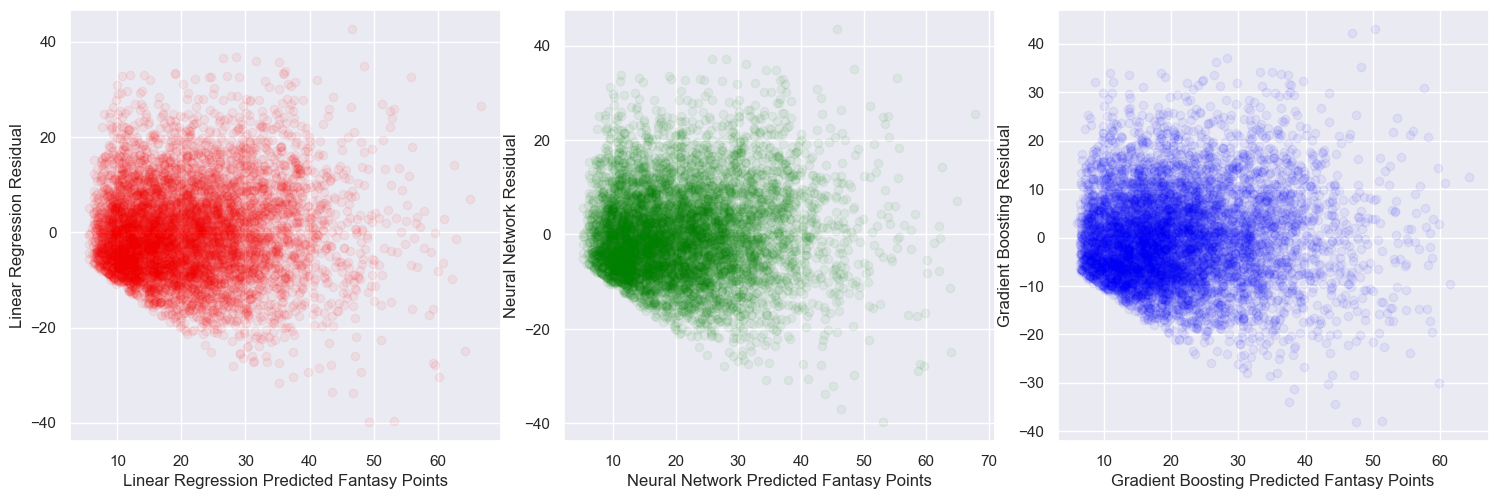

In [13]:
fig, (LR, FNN, GBR) = plt.subplots(1, 3,figsize=(15,5));
fig.tight_layout()

LR.scatter(x = linear_regression_predictions, y = y_test - linear_regression_predictions,color='red',alpha=0.06)
FNN.scatter(x = mlp_predictions, y = y_test - mlp_predictions, color='green',alpha=0.06)
GBR.scatter(x = gb_predictions, y = y_test - gb_predictions, color='blue',alpha=0.06)

LR.set_xlabel('Linear Regression Predicted Fantasy Points')
FNN.set_xlabel('Neural Network Predicted Fantasy Points')
GBR.set_xlabel('Gradient Boosting Predicted Fantasy Points')

LR.set_ylabel('Linear Regression Residual')
FNN.set_ylabel('Neural Network Residual')
GBR.set_ylabel('Gradient Boosting Residual')

In [14]:
gb_final = GradientBoostingRegressor(random_state=4)                                                             
gb_final.fit(X, y)   

optimization_dataset = boxscores
optimization_dataset['PredictedFantasyPoints'] = gb_final.predict(boxscores[['movingplayAST','movingplayTO','movingplaySTL','movingplayBLK','movingplayTRB','movingplayFTA','movingplayFT%','dummyplayStat']]) 

player_results = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/fantasy_basketball/target_games.csv')
# player_results = pd.read_csv('target_games.csv')

predicted_fantasy_points = (
    optimization_dataset.query("gmDate == '2017-12-25'")
    [["playDispNm", "PredictedFantasyPoints"]]
)

player_results = pd.merge(
    left = player_results,
    right = predicted_fantasy_points,
    left_on = "Player",
    right_on = "playDispNm",
)

In [15]:
pd.set_option('display.expand_frame_repr', False)
player_results['Points/Salary Ratio'] = 1000*player_results['PredictedFantasyPoints']/player_results['Salary']    #we multiple the fantasy vs salary ratio by 1000 for better visualization
player_results.sort_values(by='PredictedFantasyPoints',ascending=False).head(5)

,Player,Pos,Team,Opp,Salary,playDispNm,PredictedFantasyPoints,Points/Salary Ratio
4,Joel Embiid,C,PHI,@ NYK,9500,Joel Embiid,51.313689,5.401441
0,James Harden,PG,HOU,@ OKC,11100,James Harden,48.809577,4.397259
1,LeBron James,SF,CLE,@ GSW,11000,LeBron James,48.149718,4.377247
2,Russell Westbrook,PG,OKC,vs HOU,10900,Russell Westbrook,44.007224,4.037360
3,Kevin Durant,SF,GSW,vs CLE,10500,Kevin Durant,43.438575,4.137007


In [16]:
indices = player_results.Player
points = dict(zip(indices, player_results.PredictedFantasyPoints))
salaries = dict(zip(indices, player_results.Salary))
S = 30000

m = gp.Model();        # this defines the model that we'll add to as we finish the formulation

Restricted license - for non-production use only - expires 2025-11-24


In [17]:
y = m.addVars(player_results.Player, vtype=gp.GRB.BINARY, name="y")

In [18]:
# since we are maximizing points the last argument here is GRB.MAXIMIZE
m.setObjective(gp.quicksum(points[i]*y[i] for i in indices), gp.GRB.MAXIMIZE)

In [19]:
player_position_map = list(zip(player_results.Player, player_results.Pos))
for j in player_results.Pos:
    m.addConstr(gp.quicksum([y[i] for i, pos in player_position_map if pos==j])==1)

In [20]:
m.addConstr(gp.quicksum(salaries[i]*y[i] for i in indices) <= S, name="salary");       
#the budget for the selected team must not exceed 30,000

In [21]:
m.optimize()  #we optimize our model

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-10710U CPU @ 1.10GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 97 rows, 96 columns and 2082 nonzeros
Model fingerprint: 0x90509d6e
Variable types: 0 continuous, 96 integer (96 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [7e+00, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+04]
Found heuristic solution: objective 126.1046919
Presolve removed 91 rows and 57 columns
Presolve time: 0.01s
Presolved: 6 rows, 39 columns, 78 nonzeros
Found heuristic solution: objective 156.7777076
Variable types: 0 continuous, 39 integer (39 binary)

Root relaxation: objective 1.736178e+02, 7 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf |

In [22]:
vars = m.getVars()

results = (
    player_results
    .iloc[[v.index for v in vars if v.x > 1e-6]]
    [['Player','Pos','PredictedFantasyPoints','Salary']]
)
for i in results.index:
    print(vars[i].varname, vars[i].x)

print('Total fantasy score: ', m.objVal)

y[Joel Embiid] 1.0
y[Dario Saric] 1.0
y[Trevor Ariza] 1.0
y[Jarrett Jack] 1.0
y[Markieff Morris] 1.0
Total fantasy score:  171.91892913632245


# Código para las comparaciones

In [23]:
FITNESS_OBJETIVO = 171.918929          # Valor objetivo
repeticiones = 200              # Número de ejecuciones

In [24]:
def gurobi():
    resultados = []
    
    def agregar_resultado(resultado):
        resultados.append({
            "Modelo": 'Gurobi',
            "run": run,
            "mejor_fitness": resultado["mejor_fitness"],
            "tiempo_ejecucion": resultado["tiempo_ejecucion"],
            "alcanzo_optimo": resultado["alcanzo_optimo"],
        })
    
    print("Ejecutando Random Search...")
    for run in range(repeticiones):
        inicio = time.time()
        
        m.optimize()  #we optimize our model
        
        
        # Ejecutar random search
        mejor_fitness = m.objVal  #we optimize our model
        
        tiempo_ejecucion = time.time() - inicio
        
        agregar_resultado({
            "mejor_fitness": mejor_fitness,
            "tiempo_ejecucion": tiempo_ejecucion,
            "alcanzo_optimo": mejor_fitness >= FITNESS_OBJETIVO,
        })

    return pd.DataFrame(resultados)

In [25]:
df_resultados_gurobi = gurobi()

df_resultados_gurobi.to_csv("comparacion_prueba.csv", mode='a', index=False)

Ejecutando Random Search...
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-10710U CPU @ 1.10GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 97 rows, 96 columns and 2082 nonzeros
Model fingerprint: 0x90509d6e
Variable types: 0 continuous, 96 integer (96 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [7e+00, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+04]
Presolved: 6 rows, 39 columns, 78 nonzeros

Continuing optimization...


Cutting planes:
  Gomory: 1
  GUB cover: 1

Explored 1 nodes (10 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 12 (of 12 available processors)

Solution count 3: 171.919 156.778 126.105 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.719189291363e+02, best bound 1.719189291363e+02, gap 0.0000%
Gurobi Optimi